# Anand Mysorekar

## Cogs 118a FA24 Final Project

# Abstract

This project explores how three popular classification models—Random Forest, Support Vector Machine (SVM), and Logistic Regression—perform on binary classification tasks using datasets from the UCI Machine Learning Repository. Each dataset was set up for binary classification, and the models were tested under different train/test splits (20/80, 50/50, and 80/20) with hyperparameter tuning to optimize their performance. To evaluate the models, I compared their validation, and test accuracies across the splits. The results showed that Random Forest consistently came out on top, delivering the highest accuracy across all the datasets. Meanwhile, SVM and Logistic Regression showed their own strengths, depending on how complex the data was and how the features were distributed. Overall, this project highlights how choosing the right model and carefully tuning its hyperparameters can make a big difference, especially when dealing with different types of datasets and training/testing ratios.

# Introduction

Classification is a core task in machine learning, where the goal is to sort inputs into specific categories. Binary classification, in particular, has tons of real-world applications, like spotting spam emails, diagnosing medical conditions, or predicting whether a customer will leave a service. Choosing the right classification model is key to achieving good accuracy and making sure it works well across different datasets.

How well a classifier performs often depends on the characteristics of the dataset—things like the number of features, how much training data is available, and how the data is distributed. Testing multiple classifiers on the same datasets can help uncover their strengths, weaknesses, and how well they generalize.

In this project, I’m comparing the performance of three popular classification models on three datasets. By testing them with different train/test splits and tweaking their hyperparameters, I aim to understand their behavior and identify trends and best practices for choosing the right model.

# Data Preprocessing

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

## Dataset 1: [Adult](http://archive.ics.uci.edu/dataset/2/adult)
Predicting whether annual income of an individual exceeds $50K/yr based on census data. 48,842 instances, 14 features.


### Load data and assign column names

In [2]:
column_names = [
    "age",
    "class",
    "fnlwgt", # drop
    "education_level",
    "education-num", # drop
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital_gains",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "salary"
]


adult_dataset = pd.read_csv('adult_dataset/adult.data', names=column_names) # read the dataset
adult_dataset = adult_dataset.drop(columns=["fnlwgt", "education-num"]) # drop these columns
adult_dataset = adult_dataset[~adult_dataset.map(lambda x: str(x).strip()).isin(['?']).any(axis=1)] # remove rows with missing values

print(adult_dataset.dtypes)
adult_dataset.head()

age                 int64
class              object
education_level    object
marital_status     object
occupation         object
relationship       object
race               object
sex                object
capital_gains       int64
capital_loss        int64
hours_per_week      int64
native_country     object
salary             object
dtype: object


,age,class,education_level,marital_status,occupation,relationship,race,sex,capital_gains,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Most of the features are categorical, so we will need to encode them before training the models. Many of the features have lots of possible values, so we will group them into fewer categories to reduce the dimensionality of the data.


### Group similar values for dimensionality reduction for effecient encoding

In [ ]:
def map_var(col, mapping):
    adult_dataset[col] = adult_dataset[col].str.strip()
    adult_dataset[col] = adult_dataset[col].map(mapping)
    print(adult_dataset[col].unique())

class_mapping = {
    'Private': 'Private',
    'Self-emp-not-inc': 'Self-employed',
    'Self-emp-inc': 'Self-employed',
    'Federal-gov': 'Government',
    'Local-gov': 'Government',
    'State-gov': 'Government',
    'Without-pay': 'Other',
    'Never-worked': 'Other'
}

education_mapping = {
    'Bachelors': 'Undergraduate',
    'Some-college': 'Undergraduate',
    'Assoc-acdm': 'Undergraduate',
    'Assoc-voc': 'Undergraduate',
    'Masters': 'Postgraduate',
    'Doctorate': 'Postgraduate',
    'Prof-school': 'Postgraduate',
    'HS-grad': 'Lower Education',
    '12th': 'Lower Education',
    '11th': 'Lower Education',
    '10th': 'Lower Education',
    '9th': 'Lower Education',
    '7th-8th': 'Lower Education',
    '5th-6th': 'Lower Education',
    '1st-4th': 'Lower Education',
    'Preschool': 'Lower Education'
}

marital_mapping = {
    'Never-married': 'Single',
    'Married-civ-spouse': 'Married',
    'Married-AF-spouse': 'Married',
    'Divorced': 'Previously Married',
    'Separated': 'Previously Married',
    'Widowed': 'Previously Married',
    'Married-spouse-absent': 'Married'
}

occupation_mapping = {
    'Tech-support': 'White-collar',
    'Craft-repair': 'Blue-collar',
    'Other-service': 'Service',
    'Sales': 'White-collar',
    'Exec-managerial': 'White-collar',
    'Prof-specialty': 'White-collar',
    'Handlers-cleaners': 'Blue-collar',
    'Machine-op-inspct': 'Blue-collar',
    'Adm-clerical': 'White-collar',
    'Farming-fishing': 'Blue-collar',
    'Transport-moving': 'Blue-collar',
    'Priv-house-serv': 'Service',
    'Protective-serv': 'Service',
    'Armed-Forces': 'Military'
}

relationship_mapping = {
    'Wife': 'Spouse',
    'Husband': 'Spouse',
    'Own-child': 'Dependent',
    'Not-in-family': 'Unrelated',
    'Other-relative': 'Dependent',
    'Unmarried': 'Unrelated'
}

race_mapping = {
    'White': 'White',
    'Black': 'Black',
    'Asian-Pac-Islander': 'Asian',
    'Amer-Indian-Eskimo': 'Indigenous',
    'Other': 'Other'
}

sex_mapping = {
    'Male': 1,
    'Female': 0
}

country_mapping = {
    'United-States': 'North America',
    'Canada': 'North America',
    'Outlying-US(Guam-USVI-etc)': 'North America',
    'Puerto-Rico': 'North America',
    'Mexico': 'Latin America',
    'Cuba': 'Latin America',
    'Dominican-Republic': 'Latin America',
    'Jamaica': 'Latin America',
    'Haiti': 'Latin America',
    'Trinadad&Tobago': 'Latin America',
    'El-Salvador': 'Latin America',
    'Guatemala': 'Latin America',
    'Honduras': 'Latin America',
    'Nicaragua': 'Latin America',
    'Ecuador': 'Latin America',
    'Peru': 'Latin America',
    'Columbia': 'Latin America',
    'England': 'Europe',
    'Germany': 'Europe',
    'Italy': 'Europe',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Ireland': 'Europe',
    'France': 'Europe',
    'Greece': 'Europe',
    'Scotland': 'Europe',
    'Yugoslavia': 'Europe',
    'Hungary': 'Europe',
    'Holand-Netherlands': 'Europe',
    'Cambodia': 'Asia',
    'India': 'Asia',
    'Japan': 'Asia',
    'China': 'Asia',
    'Philippines': 'Asia',
    'Vietnam': 'Asia',
    'Laos': 'Asia',
    'Thailand': 'Asia',
    'Hong': 'Asia',
    'Taiwan': 'Asia',
    'Iran': 'Middle East',
    'South': 'Other',
    'Israel': 'Middle East',  
    'Other': 'Other'
}

salary_mapping = {
    '>50K': 1,
    '<=50K': 0
}


map_var('class', class_mapping)
map_var('education_level', education_mapping)
map_var('marital_status', marital_mapping)
map_var('occupation', occupation_mapping)
map_var('relationship', relationship_mapping)
map_var('race', race_mapping)
map_var('sex', sex_mapping)
map_var('native_country', country_mapping)
map_var('salary', salary_mapping)

['Government' 'Self-employed' 'Private' 'Other']
['Undergraduate' 'Lower Education' 'Postgraduate']
['Single' 'Married' 'Previously Married']
['White-collar' 'Blue-collar' 'Service' 'Military']
['Unrelated' 'Spouse' 'Dependent']
['White' 'Black' 'Asian' 'Indigenous' 'Other']
[1 0]
['North America' 'Latin America' 'Asia' 'Europe' 'Middle East' 'Other']
[0 1]


In [4]:
adult_dataset.head()

,age,class,education_level,marital_status,occupation,relationship,race,sex,capital_gains,capital_loss,hours_per_week,native_country,salary
0,39,Government,Undergraduate,Single,White-collar,Unrelated,White,1,2174,0,40,North America,0
1,50,Self-employed,Undergraduate,Married,White-collar,Spouse,White,1,0,0,13,North America,0
2,38,Private,Lower Education,Previously Married,Blue-collar,Unrelated,White,1,0,0,40,North America,0
3,53,Private,Lower Education,Married,Blue-collar,Spouse,Black,1,0,0,40,North America,0
4,28,Private,Undergraduate,Married,White-collar,Spouse,Black,0,0,0,40,Latin America,0


That looks much better and much more manageable. Now we can encode the data. Most of the features are nominal, meaning they don't have an inherent order, so we will use one-hot encoding to encode them. The education level variable, however, is ordinal (meaning there is some order, but the distances between them don't necessarily mean anything), so we will use label encoding for that variable.

### Encode categorical variables

In [5]:
columns_to_one_hot = ['class', 'marital_status', 'occupation', 'relationship', 'race', 'native_country']
adult_dataset = pd.get_dummies(adult_dataset, columns=columns_to_one_hot, prefix=columns_to_one_hot)

label_encoder = LabelEncoder()
adult_dataset['education_level'] = label_encoder.fit_transform(adult_dataset['education_level'])


In [6]:
print(adult_dataset.dtypes)
adult_dataset.head()


age                                  int64
education_level                      int64
sex                                  int64
capital_gains                        int64
capital_loss                         int64
hours_per_week                       int64
salary                               int64
class_Government                      bool
class_Other                           bool
class_Private                         bool
class_Self-employed                   bool
marital_status_Married                bool
marital_status_Previously Married     bool
marital_status_Single                 bool
occupation_Blue-collar                bool
occupation_Military                   bool
occupation_Service                    bool
occupation_White-collar               bool
relationship_Dependent                bool
relationship_Spouse                   bool
relationship_Unrelated                bool
race_Asian                            bool
race_Black                            bool
race_Indige

,age,education_level,sex,capital_gains,capital_loss,hours_per_week,salary,class_Government,class_Other,class_Private,...,race_Black,race_Indigenous,race_Other,race_White,native_country_Asia,native_country_Europe,native_country_Latin America,native_country_Middle East,native_country_North America,native_country_Other
0,39,2,1,2174,0,40,0,True,False,False,...,False,False,False,True,False,False,False,False,True,False
1,50,2,1,0,0,13,0,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,38,0,1,0,0,40,0,False,False,True,...,False,False,False,True,False,False,False,False,True,False
3,53,0,1,0,0,40,0,False,False,True,...,True,False,False,False,False,False,False,False,True,False
4,28,2,0,0,0,40,0,False,False,True,...,True,False,False,False,False,False,True,False,False,False


Now that each feature is in the format a machine can handle and intepret properly, the data is ready for modeling!

## Dataset 2: [Heart Disease](http://archive.ics.uci.edu/dataset/45/heart+disease)
Heart disease dataset from four databases predicting if a person has heart disease based on various features. 3 of the databases were riddled with missing values, so we will use the Cleveland database. 303 instances, 14 features.


### Load data and assign column names


In [ ]:
column_names = ["age", "sex", "cp", "resting_bp", "cholesterol", "blood_sugar", "resting_ekg", "max_hr", "exang", "oldpeak", "slope", "ca", "thal", "severity"]

heart_dataset = pd.read_csv('heart_dataset/processed.cleveland.data', header=None, names=column_names) # read the dataset
heart_dataset = heart_dataset[~heart_dataset.map(lambda x: str(x).strip()).isin(['?']).any(axis=1)] # remove rows with missing values
heart_dataset['ca'] = heart_dataset['ca'].astype(float) # convert to float
heart_dataset['thal'] = heart_dataset['thal'].astype(float) # convert to float
heart_dataset['severity'] = heart_dataset['severity'].apply(lambda x: 0 if x == 0 else 1) # convert to binary for 2 class classification

print(heart_dataset.dtypes)
heart_dataset.head()

age            float64
sex            float64
cp             float64
resting_bp     float64
cholesterol    float64
blood_sugar    float64
resting_ekg    float64
max_hr         float64
exang          float64
oldpeak        float64
slope          float64
ca             float64
thal           float64
severity         int64
dtype: object


,age,sex,cp,resting_bp,cholesterol,blood_sugar,resting_ekg,max_hr,exang,oldpeak,slope,ca,thal,severity
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


This dataset is already clean and ready for modeling, so we are done!

## Dataset 3: [Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality)
Wine dataset. Predicting the quality of wine based on various features. Red wine has 1599 instances, white wine has 4898. They both have 11 features.


### Load data and assign column names

Since the qualities of a good red wine might be different from those of a good white wine, I will split the dataset into two and model them separately, as well as model the combined dataset.

In [8]:
red_wine_dataset = pd.read_csv('wine_dataset/winequality-red.csv', sep=';') # read the dataset
white_wine_dataset = pd.read_csv('wine_dataset/winequality-white.csv', sep=';') # read the dataset
red_white_wine_dataset = pd.concat([red_wine_dataset, white_wine_dataset], axis=0) # concatenate the datasets
wine_datasets = [red_wine_dataset, white_wine_dataset, red_white_wine_dataset] 

for i, dataset in enumerate(wine_datasets, start=1):
    dataset['quality'] = dataset['quality'].apply(lambda x: 0 if x <= 6 else 1) # convert to binary for 2 class classification

In [9]:
print(red_wine_dataset.dtypes)
red_wine_dataset.head()

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [10]:
print(red_wine_dataset.dtypes)
white_wine_dataset.head()

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0


In [11]:
print(red_white_wine_dataset.dtypes)
red_white_wine_dataset.head()

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


This dataset is already clean and ready for modeling. 

# Methods

I am going to use the following models for each dataset: Support Vector Machine, Random Forest, and Logistic Regression. For each of the models I will:

- Preprocess the data
    - Scale the data using StandardScaler to standardize the input values for better model performance
    - Separate the data into features and target column

- Partition the data into training and testing sets
    - Use 20/80, 50/50, and 80/20 splits to evaluate model performance under different training/testing ratios

- Perform hyperparameter tuning using GridSearchCV
    - Tune the hyperparameters for each model to optimize performance

- Train the model
    - Fit the model on the training data for each partition using the best hyperparameters

- Evaluate the model
    - Evaluate the model using cross scores to compute the average validation accuracy
    - Evaluate the model on the test set to compute the test accuracy
    - Generate classification reports to analyze precision, recall, and F1 scores



# Models

In [ ]:
def svm(df, target_column):

    # Prepare features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Define partitions (test/train split ratios)
    partitions = {
        "20/80": 0.2,
        "50/50": 0.5,
        "80/20": 0.8
    }
    
    results = []  # Store results for analysis
    for partition_name, test_size in tqdm(partitions.items(), desc="Partitions"):
        
        for run in range(1, 4):  # Repeat for 3 rounds to compute averages
            
            # Split data into training and testing
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=run)

            # Define hyperparameter grid
            param_grid = {
                'C': [0.1, 1, 10, 100], 
                'gamma': ['scale', 0.1],  
                'kernel': ['rbf']
            }

            # Perform grid search with cross-validation
            grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
            grid_search.fit(X_train, y_train)
            
            # Get the best model and hyperparameter details
            best_model = grid_search.best_estimator_
            cv_results = pd.DataFrame(grid_search.cv_results_)
            training_scores = cv_results["mean_train_score"]
            validation_scores = cv_results["mean_test_score"]
            
            # Evaluate on test set
            y_pred = best_model.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_pred)
            
            # Store results
            results.append({
                "Partition": partition_name,
                "Round": run,
                "CV Accuracy": validation_scores.max(),
                "Test Accuracy": test_accuracy,
                "Training Scores": training_scores.tolist(),
                "Validation Scores": validation_scores.tolist(),
                "Best Model": best_model,
                "X_test": X_test,
                "y_test": y_test
            })
    
    # Summarize results across rounds
    results_df = pd.DataFrame(results)
    numeric_columns = ["CV Accuracy", "Test Accuracy"]
    avg_results = results_df.groupby("Partition")[numeric_columns].mean().reset_index()
    print("\nSummary of Results (Averaged Across Rounds):")
    print(avg_results)
    
    # Find the best overall result
    best_result = results_df.loc[results_df['Test Accuracy'].idxmax()]
    best_partition = best_result["Partition"]
    best_cv_accuracy = best_result["CV Accuracy"]
    best_test_accuracy = best_result["Test Accuracy"]
    best_training_scores = best_result["Training Scores"]
    best_validation_scores = best_result["Validation Scores"]
    best_model = best_result["Best Model"]
    best_X_test = best_result["X_test"]
    best_y_test = best_result["y_test"]
    
    # Print the best split results
    print(f"\nBest Overall Partition: {best_partition}")
    print(f"Validation Accuracy: {best_cv_accuracy:.2f}")
    print(f"Test Accuracy: {best_test_accuracy:.2f}")
    
    # Plot training vs validation accuracy for the best partition
    plt.plot(best_training_scores, label="Training Accuracy")
    plt.plot(best_validation_scores, label="Validation Accuracy")
    plt.title(f"Training vs Validation Accuracy (Best Partition: {best_partition})")
    plt.xlabel("Hyperparameter Configurations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Print classification report and display confusion matrix for the best partition
    print("\nClassification Report for Best Partition:")
    print(classification_report(best_y_test, best_model.predict(best_X_test)))
    ConfusionMatrixDisplay.from_estimator(best_model, best_X_test, best_y_test)
    plt.title(f"Confusion Matrix: {best_partition} Partition")
    plt.show()

def random_forest(df, target_column):

    # Prepare features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Define partitions
    partitions = {
        "20/80": 0.2,
        "50/50": 0.5,
        "80/20": 0.8
    }
    
    results = []  # Store results for analysis
    for partition_name, test_size in tqdm(partitions.items(), desc="Partitions"):
        
        for run in range(1, 4):  # Repeat for 3 rounds to compute averages
            
            # Split data into training and testing
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=run)

            # Define hyperparameter grid
            param_grid = {
                'n_estimators': [50, 100, 200],  
                'max_depth': [None, 10, 20], 
                'min_samples_split': [2, 5, 10],
                'bootstrap': [True, False]
            }

            # Perform grid search with cross-validation
            grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
            grid_search.fit(X_train, y_train)
            
            # Get the best model and hyperparameter details
            best_model = grid_search.best_estimator_
            cv_results = pd.DataFrame(grid_search.cv_results_)
            training_scores = cv_results["mean_train_score"]
            validation_scores = cv_results["mean_test_score"]
            
            # Evaluate on test set
            y_pred = best_model.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_pred)
            
            # Store results
            results.append({
                "Partition": partition_name,
                "Round": run,
                "CV Accuracy": validation_scores.max(),
                "Test Accuracy": test_accuracy,
                "Training Scores": training_scores.tolist(),
                "Validation Scores": validation_scores.tolist(),
                "Best Model": best_model,
                "X_test": X_test,
                "y_test": y_test
            })
    
    # Summarize results across rounds
    results_df = pd.DataFrame(results)
    numeric_columns = ["CV Accuracy", "Test Accuracy"]
    avg_results = results_df.groupby("Partition")[numeric_columns].mean().reset_index()
    print("\nSummary of Results (Averaged Across Rounds):")
    print(avg_results)
    
    # Find the best overall result
    best_result = results_df.loc[results_df['Test Accuracy'].idxmax()]
    best_partition = best_result["Partition"]
    best_cv_accuracy = best_result["CV Accuracy"]
    best_test_accuracy = best_result["Test Accuracy"]
    best_training_scores = best_result["Training Scores"]
    best_validation_scores = best_result["Validation Scores"]
    best_model = best_result["Best Model"]
    best_X_test = best_result["X_test"]
    best_y_test = best_result["y_test"]
    
    # Print the best split results
    print(f"\nBest Overall Partition: {best_partition}")
    print(f"Validation Accuracy: {best_cv_accuracy:.2f}")
    print(f"Test Accuracy: {best_test_accuracy:.2f}")
    
    # Plot training vs validation accuracy for the best partition
    plt.plot(best_training_scores, label="Training Accuracy")
    plt.plot(best_validation_scores, label="Validation Accuracy")
    plt.title(f"Training vs Validation Accuracy (Best Partition: {best_partition})")
    plt.xlabel("Hyperparameter Configurations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Print classification report and display confusion matrix for the best partition
    print("\nClassification Report for Best Partition:")
    print(classification_report(best_y_test, best_model.predict(best_X_test)))
    ConfusionMatrixDisplay.from_estimator(best_model, best_X_test, best_y_test)
    plt.title(f"Confusion Matrix: {best_partition} Partition")
    plt.show()

def logistic_regression(df, target_column):

    # Prepare features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Define partitions
    partitions = {
        "20/80": 0.2,
        "50/50": 0.5,
        "80/20": 0.8
    }
    
    results = []  # Store results for analysis
    for partition_name, test_size in tqdm(partitions.items(), desc="Partitions"):
        
        for run in range(1, 4):  # Repeat for 3 rounds to compute averages
            
            # Split data into training and testing
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=run)

            # Define hyperparameter grid
            param_grid = {
                'C': [0.1, 1, 10, 100],  
                'penalty': ['l1', 'l2'],  
                'solver': ['liblinear', 'saga'],
                'fit_intercept': [True, False]
            }

            # Perform grid search with cross-validation
            grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
            grid_search.fit(X_train, y_train)
            
            # Get the best model and hyperparameter details
            best_model = grid_search.best_estimator_
            cv_results = pd.DataFrame(grid_search.cv_results_)
            training_scores = cv_results["mean_train_score"]
            validation_scores = cv_results["mean_test_score"]
            
            # Evaluate on test set
            y_pred = best_model.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_pred)
            
            # Store results
            results.append({
                "Partition": partition_name,
                "Round": run,
                "CV Accuracy": validation_scores.max(),
                "Test Accuracy": test_accuracy,
                "Training Scores": training_scores.tolist(),
                "Validation Scores": validation_scores.tolist(),
                "Best Model": best_model,
                "X_test": X_test,
                "y_test": y_test
            })
    
    # Summarize results across rounds
    results_df = pd.DataFrame(results)
    numeric_columns = ["CV Accuracy", "Test Accuracy"]
    avg_results = results_df.groupby("Partition")[numeric_columns].mean().reset_index()
    print("\nSummary of Results (Averaged Across Rounds):")
    print(avg_results)
    
    # Find the best overall result
    best_result = results_df.loc[results_df['Test Accuracy'].idxmax()]
    best_partition = best_result["Partition"]
    best_cv_accuracy = best_result["CV Accuracy"]
    best_test_accuracy = best_result["Test Accuracy"]
    best_training_scores = best_result["Training Scores"]
    best_validation_scores = best_result["Validation Scores"]
    best_model = best_result["Best Model"]
    best_X_test = best_result["X_test"]
    best_y_test = best_result["y_test"]
    
    # Print the best split results
    print(f"\nBest Overall Partition: {best_partition}")
    print(f"Validation Accuracy: {best_cv_accuracy:.2f}")
    print(f"Test Accuracy: {best_test_accuracy:.2f}")
    
    # Plot training vs validation accuracy for the best partition
    plt.plot(best_training_scores, label="Training Accuracy")
    plt.plot(best_validation_scores, label="Validation Accuracy")
    plt.title(f"Training vs Validation Accuracy (Best Partition: {best_partition})")
    plt.xlabel("Hyperparameter Configurations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Print classification report and display confusion matrix for the best partition
    print("\nClassification Report for Best Partition:")
    print(classification_report(best_y_test, best_model.predict(best_X_test)))
    ConfusionMatrixDisplay.from_estimator(best_model, best_X_test, best_y_test)
    plt.title(f"Confusion Matrix: {best_partition} Partition")
    plt.show()

# Experiments

In [13]:
def run_model(model_fn, dataset_info):
    for i, dataset_info in enumerate(tqdm(datasets, desc="Datasets"), start=1):
        dataset_name = dataset_info["name"]
        dataset = dataset_info["data"]
        target_column = dataset_info["target"]
        print(f"\nTraining on '{dataset_name}' with target column '{target_column}'...")
        model_fn(dataset, target_column)

        
datasets = [
    {"name": "Adult Dataset", "data": adult_dataset, "target": "salary"},
    {"name": "Heart Dataset", "data": heart_dataset, "target": "severity"},
    {"name": "Red Wine Dataset", "data": red_wine_dataset, "target": "quality"},
    {"name": "White Wine Dataset", "data": white_wine_dataset, "target": "quality"},
    {"name": "Red and White Wine Dataset", "data": red_white_wine_dataset, "target": "quality"}
]


### Running SVM

Datasets:   0%|          | 0/5 [00:00<?, ?it/s]


Training on 'Adult Dataset' with target column 'salary'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\anand\anaconda3\envs\cogs118a\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.843383       0.847892
1     50/50     0.842185       0.844727
2     80/20     0.832670       0.837560

Best Overall Partition: 20/80
Validation Accuracy: 0.84
Test Accuracy: 0.85


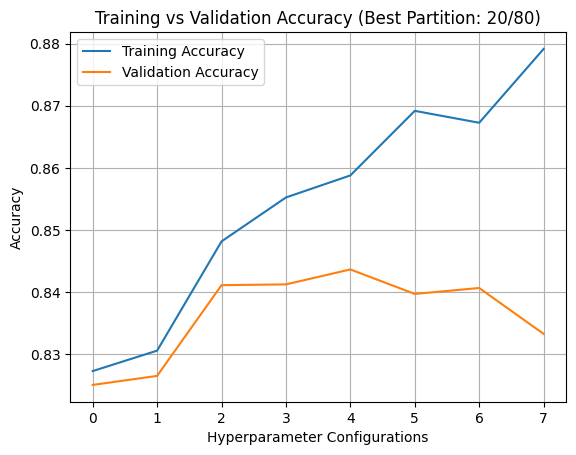


Classification Report for Best Partition:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4478
           1       0.75      0.63      0.68      1555

    accuracy                           0.85      6033
   macro avg       0.81      0.78      0.79      6033
weighted avg       0.84      0.85      0.85      6033



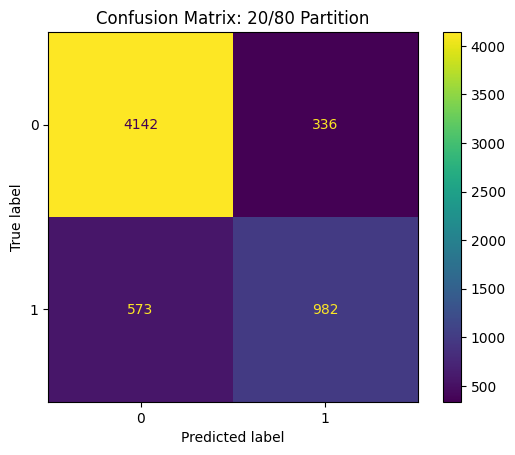


Training on 'Heart Dataset' with target column 'severity'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.833954       0.822222
1     50/50     0.817548       0.823266
2     80/20     0.813636       0.810924

Best Overall Partition: 50/50
Validation Accuracy: 0.80
Test Accuracy: 0.85


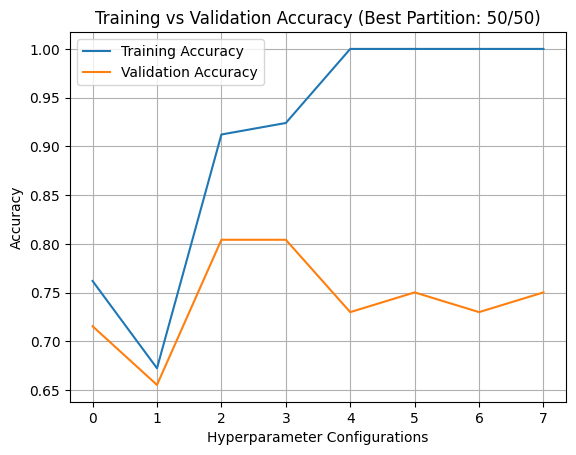


Classification Report for Best Partition:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        76
           1       0.86      0.84      0.85        73

    accuracy                           0.85       149
   macro avg       0.85      0.85      0.85       149
weighted avg       0.85      0.85      0.85       149



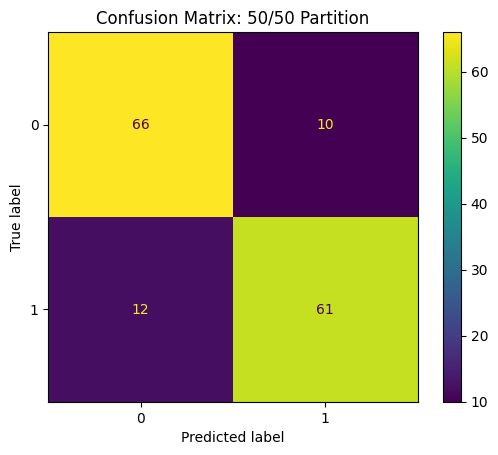


Training on 'Red Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.884025       0.907292
1     50/50     0.879830       0.880000
2     80/20     0.873694       0.869792

Best Overall Partition: 20/80
Validation Accuracy: 0.88
Test Accuracy: 0.92


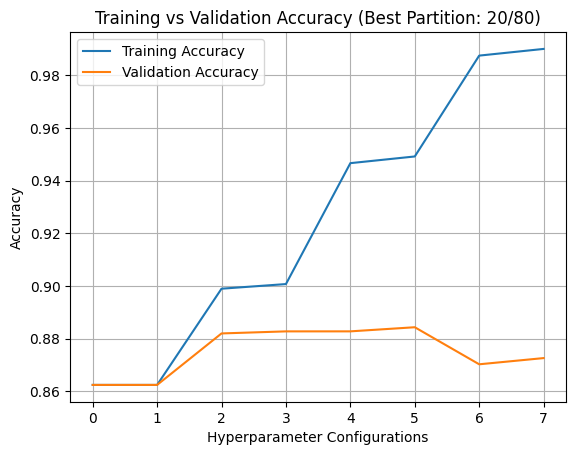


Classification Report for Best Partition:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       279
           1       0.72      0.56      0.63        41

    accuracy                           0.92       320
   macro avg       0.83      0.76      0.79       320
weighted avg       0.91      0.92      0.91       320



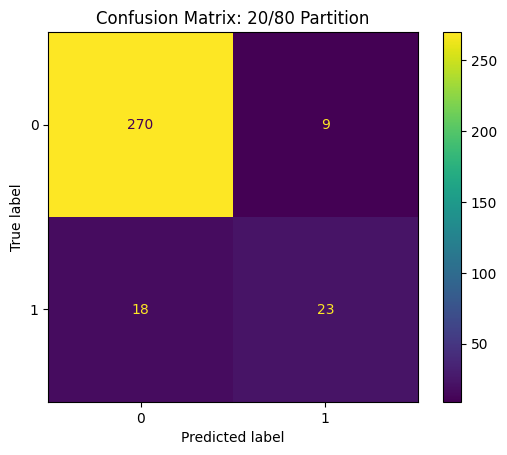


Training on 'White Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.842095       0.831293
1     50/50     0.819387       0.829726
2     80/20     0.819217       0.812112

Best Overall Partition: 20/80
Validation Accuracy: 0.84
Test Accuracy: 0.85


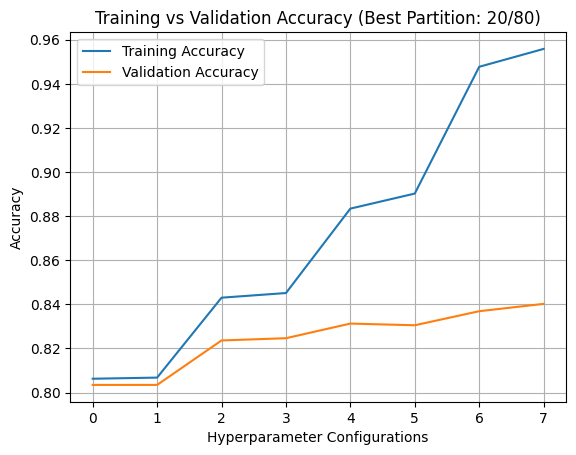


Classification Report for Best Partition:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       774
           1       0.65      0.60      0.62       206

    accuracy                           0.85       980
   macro avg       0.77      0.76      0.76       980
weighted avg       0.84      0.85      0.84       980



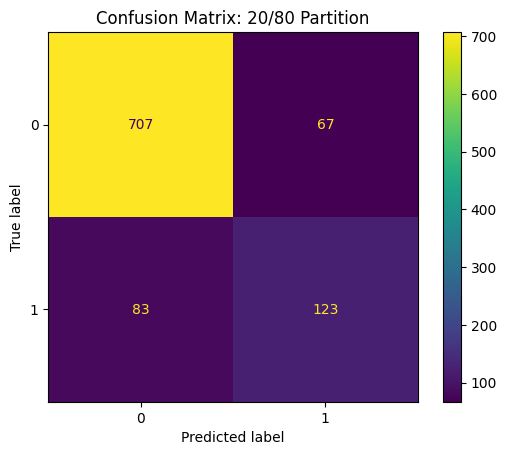


Training on 'Red and White Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.845747       0.858718
1     50/50     0.839903       0.836668
2     80/20     0.825250       0.827177

Best Overall Partition: 20/80
Validation Accuracy: 0.84
Test Accuracy: 0.86


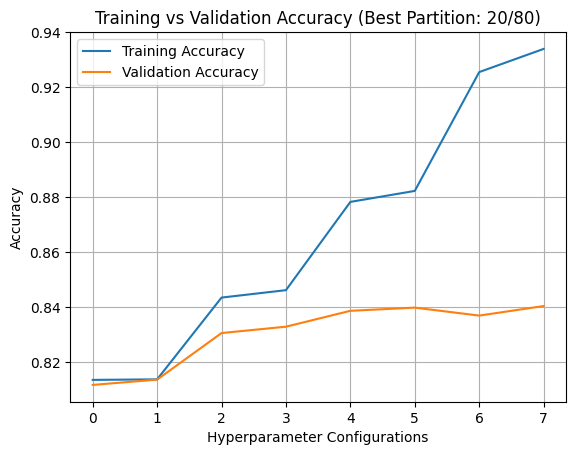


Classification Report for Best Partition:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1058
           1       0.66      0.55      0.60       242

    accuracy                           0.86      1300
   macro avg       0.78      0.74      0.76      1300
weighted avg       0.86      0.86      0.86      1300



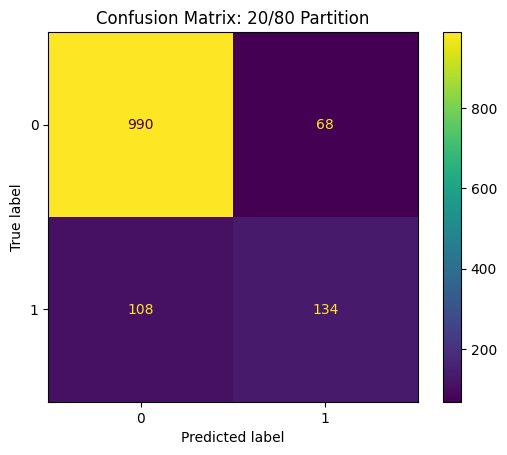

In [14]:
run_model(svm, datasets)

### Running random forest

Datasets:   0%|          | 0/5 [00:00<?, ?it/s]


Training on 'Adult Dataset' with target column 'salary'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.856176       0.858169
1     50/50     0.855911       0.854873
2     80/20     0.849249       0.852507

Best Overall Partition: 20/80
Validation Accuracy: 0.86
Test Accuracy: 0.86


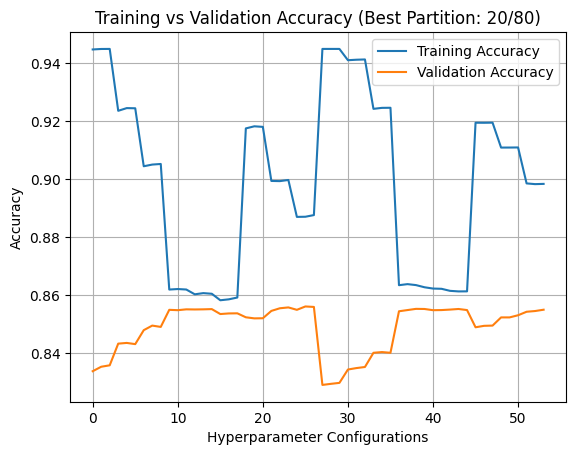


Classification Report for Best Partition:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4483
           1       0.79      0.62      0.69      1550

    accuracy                           0.86      6033
   macro avg       0.83      0.78      0.80      6033
weighted avg       0.85      0.86      0.85      6033



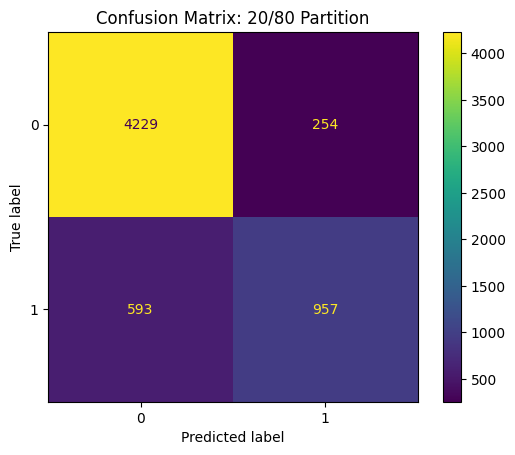


Training on 'Heart Dataset' with target column 'severity'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.821336       0.861111
1     50/50     0.839923       0.827740
2     80/20     0.808081       0.801120

Best Overall Partition: 20/80
Validation Accuracy: 0.83
Test Accuracy: 0.88


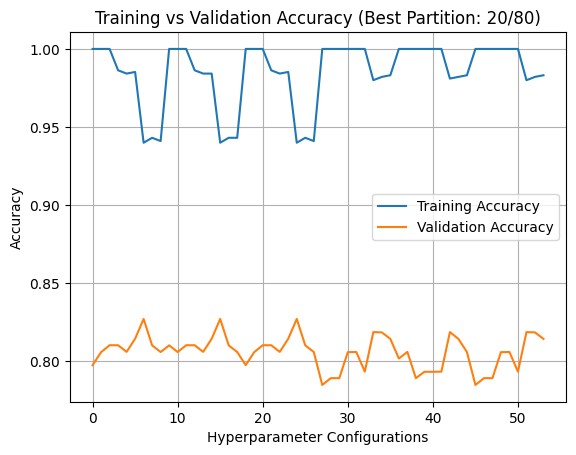


Classification Report for Best Partition:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        31
           1       0.89      0.86      0.88        29

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



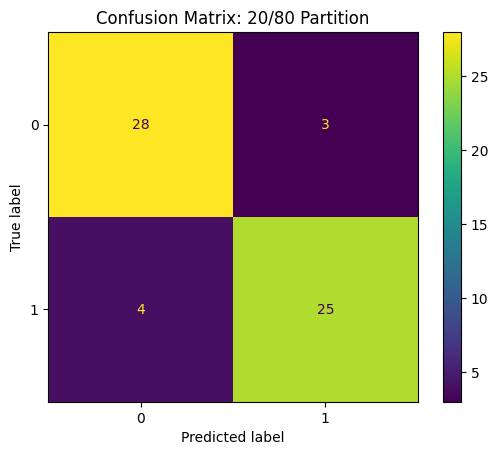


Training on 'Red Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.908786       0.923958
1     50/50     0.889458       0.904167
2     80/20     0.885152       0.882031

Best Overall Partition: 20/80
Validation Accuracy: 0.90
Test Accuracy: 0.93


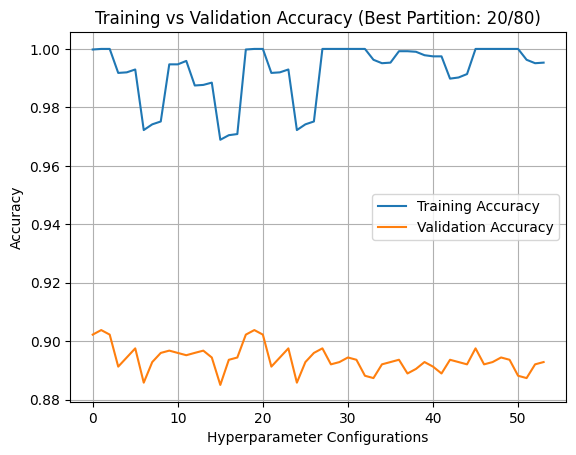


Classification Report for Best Partition:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       283
           1       0.78      0.57      0.66        37

    accuracy                           0.93       320
   macro avg       0.86      0.77      0.81       320
weighted avg       0.93      0.93      0.93       320



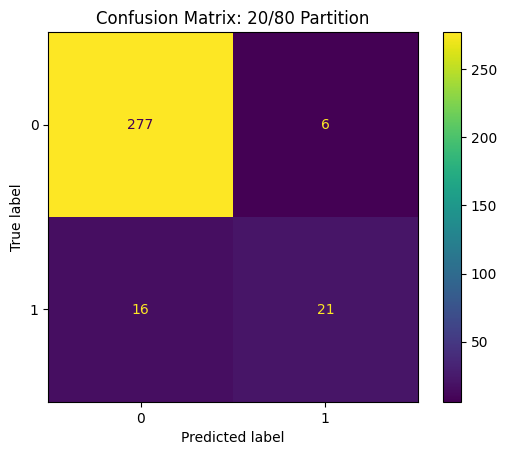


Training on 'White Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.875444       0.884014
1     50/50     0.854365       0.865251
2     80/20     0.836246       0.829208

Best Overall Partition: 20/80
Validation Accuracy: 0.88
Test Accuracy: 0.89


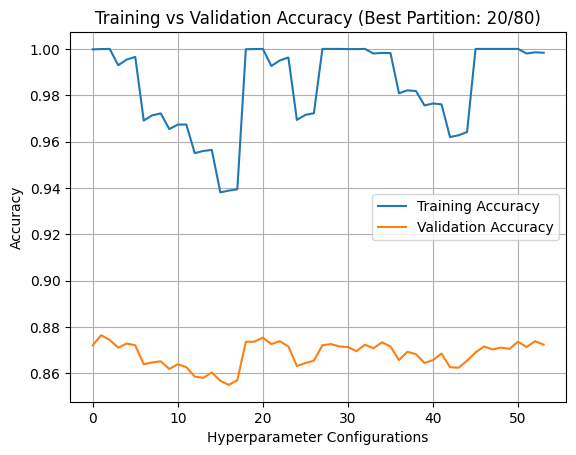


Classification Report for Best Partition:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       759
           1       0.85      0.62      0.72       221

    accuracy                           0.89       980
   macro avg       0.87      0.79      0.82       980
weighted avg       0.89      0.89      0.88       980



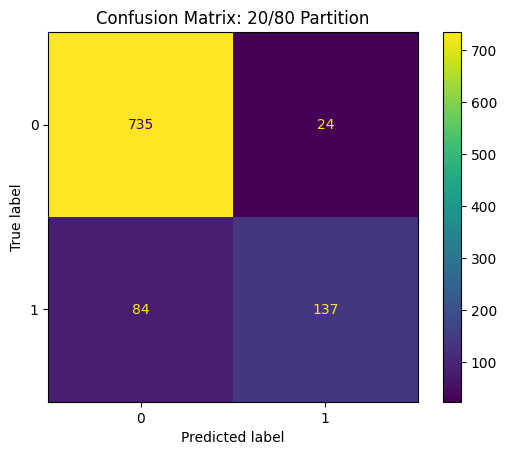


Training on 'Red and White Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.881982       0.898462
1     50/50     0.866177       0.872884
2     80/20     0.843725       0.843017

Best Overall Partition: 20/80
Validation Accuracy: 0.88
Test Accuracy: 0.91


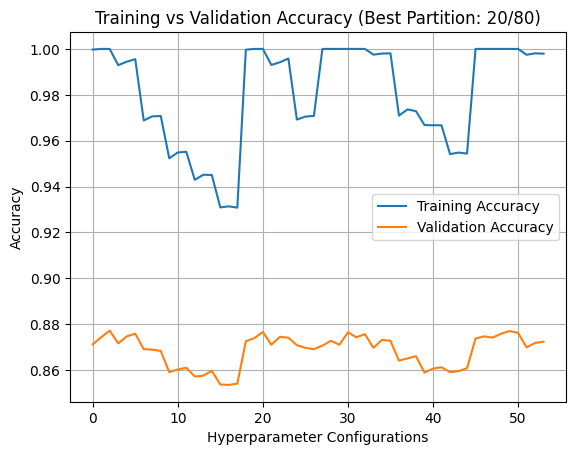


Classification Report for Best Partition:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1045
           1       0.86      0.64      0.74       255

    accuracy                           0.91      1300
   macro avg       0.89      0.81      0.84      1300
weighted avg       0.91      0.91      0.90      1300



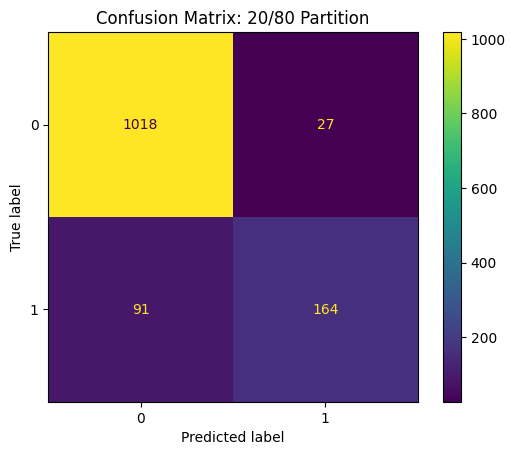

In [15]:
run_model(random_forest, datasets)

### Running logistic regression 

Datasets:   0%|          | 0/5 [00:00<?, ?it/s]


Training on 'Adult Dataset' with target column 'salary'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.834957       0.836068
1     50/50     0.834228       0.835577
2     80/20     0.831456       0.834922

Best Overall Partition: 50/50
Validation Accuracy: 0.83
Test Accuracy: 0.84


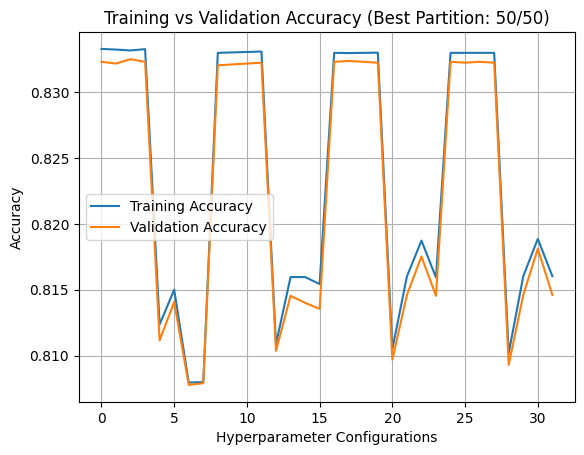


Classification Report for Best Partition:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     11315
           1       0.71      0.59      0.64      3766

    accuracy                           0.84     15081
   macro avg       0.79      0.76      0.77     15081
weighted avg       0.83      0.84      0.83     15081



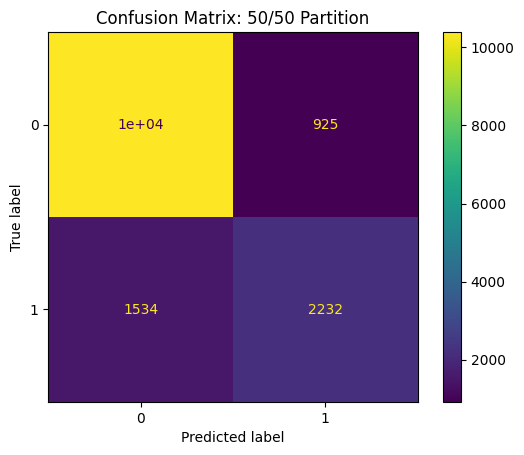


Training on 'Heart Dataset' with target column 'severity'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.839687       0.838889
1     50/50     0.848889       0.816555
2     80/20     0.829798       0.826331

Best Overall Partition: 20/80
Validation Accuracy: 0.84
Test Accuracy: 0.87


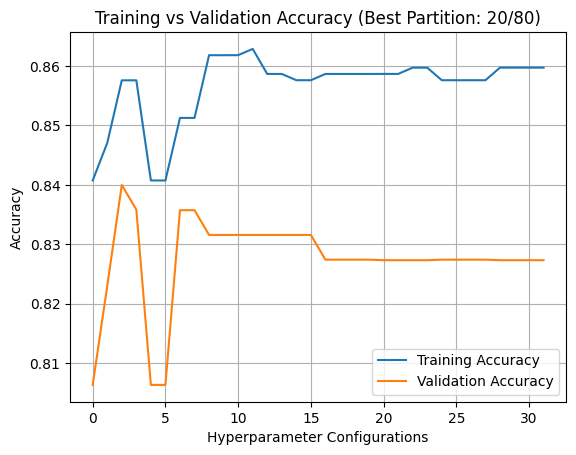


Classification Report for Best Partition:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        30
           1       0.84      0.90      0.87        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



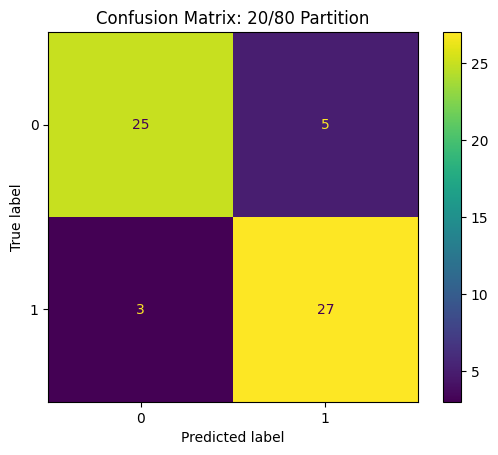


Training on 'Red Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.876990       0.891667
1     50/50     0.877353       0.882083
2     80/20     0.872619       0.872135

Best Overall Partition: 20/80
Validation Accuracy: 0.88
Test Accuracy: 0.90


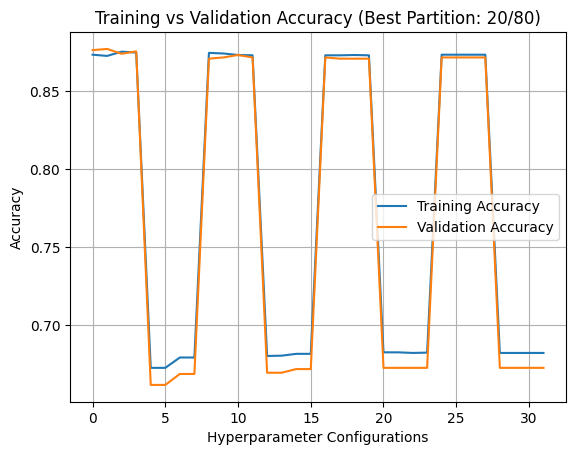


Classification Report for Best Partition:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       283
           1       0.63      0.32      0.43        37

    accuracy                           0.90       320
   macro avg       0.77      0.65      0.69       320
weighted avg       0.88      0.90      0.89       320



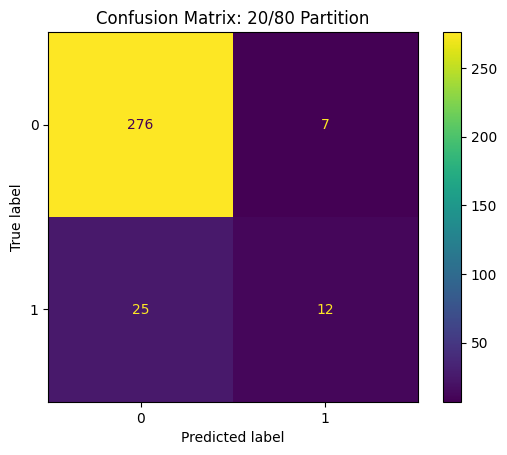


Training on 'White Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.803046       0.795578
1     50/50     0.805228       0.799918
2     80/20     0.807291       0.801480

Best Overall Partition: 20/80
Validation Accuracy: 0.80
Test Accuracy: 0.81


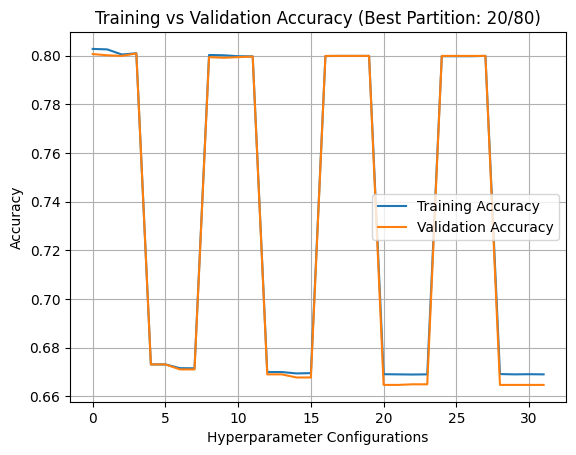


Classification Report for Best Partition:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       774
           1       0.57      0.30      0.39       206

    accuracy                           0.81       980
   macro avg       0.70      0.62      0.64       980
weighted avg       0.78      0.81      0.78       980



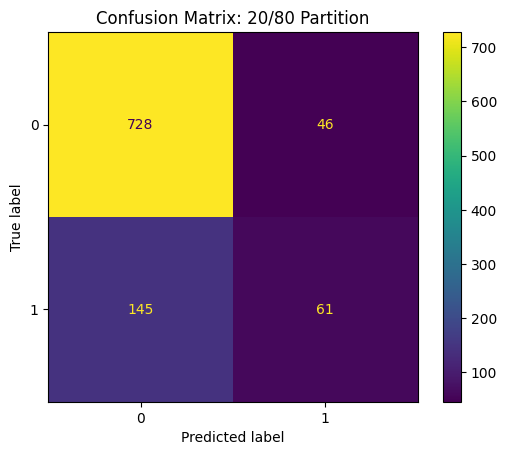


Training on 'Red and White Wine Dataset' with target column 'quality'...


Partitions:   0%|          | 0/3 [00:00<?, ?it/s]


Summary of Results (Averaged Across Rounds):
  Partition  CV Accuracy  Test Accuracy
0     20/80     0.815919       0.828462
1     50/50     0.816193       0.820868
2     80/20     0.810875       0.815249

Best Overall Partition: 20/80
Validation Accuracy: 0.82
Test Accuracy: 0.83


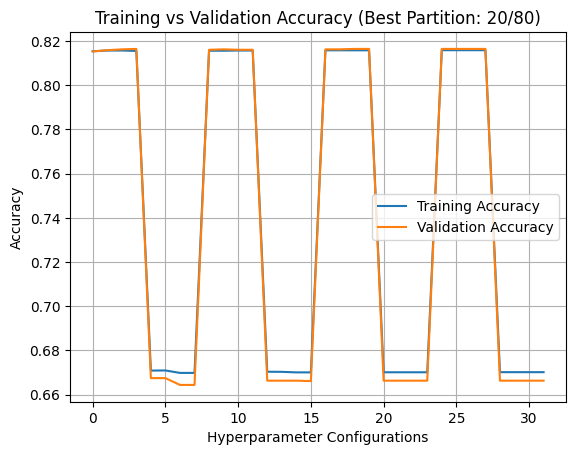


Classification Report for Best Partition:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1045
           1       0.65      0.29      0.40       255

    accuracy                           0.83      1300
   macro avg       0.75      0.63      0.65      1300
weighted avg       0.81      0.83      0.80      1300



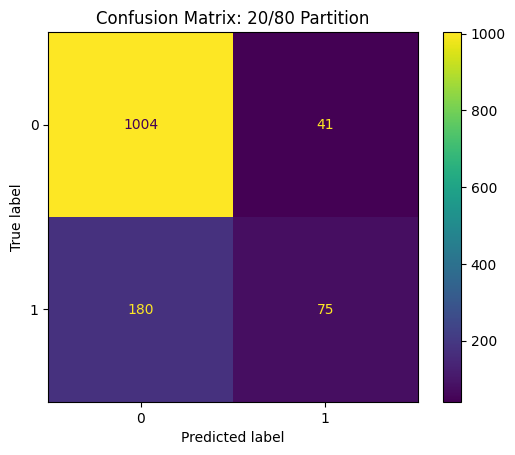

In [16]:
run_model(logistic_regression, datasets)

# Results

### SVM Analysis

| Dataset               | Best Partition (test/train) | Validation Accuracy | Test Accuracy |
|-----------------------|----------------|---------------------|---------------|
| Adult Dataset         | 20/80          | 0.84            | 0.85          |
| Heart Disease Dataset | 50/50          | 0.80              | 0.85          |
| Red Wine Dataset      | 20/80          | 0.88             | 0.92          |
| White Wine Dataset    | 20/80          | 0.84                | 0.85          |
| Combined Wine Dataset | 20/80          | 0.84                | 0.86          |

### Random Forest Analysis

| Dataset               | Best Partition (test/train) | Validation Accuracy | Test Accuracy |
|-----------------------|----------------|---------------------|---------------|
| Adult Dataset         | 20/80          | 0.86                | 0.86          |
| Heart Disease Dataset | 20/80          | 0.83                | 0.88          |
| Red Wine Dataset      | 20/80          | 0.90                | 0.93          |
| White Wine Dataset    | 20/80          | 0.88                | 0.89          |
| Combined Wine Dataset | 20/80          | 0.88                | 0.91          |

### Logistic Regression Analysis

| Dataset               | Best Partition (test/train) | Validation Accuracy | Test Accuracy |
|-----------------------|----------------|---------------------|---------------|
| Adult Dataset         | 50/50          | 0.83                | 0.84          |
| Heart Disease Dataset | 20/80          | 0.84                | 0.87          |
| Red Wine Dataset      | 20/80          | 0.88                | 0.90          |
| White Wine Dataset    | 20/80          | 0.80                | 0.81          |
| Combined Wine Dataset | 20/80          | 0.82                | 0.83          |

### Model Comparison


| **Dataset**            | **Model**               | **Best Partition (test/train)** | **Validation Accuracy** | **Test Accuracy** |
|-------------------------|-------------------------|---------------------|-------------------------|-------------------|
| **Adult Dataset**       | **Random Forest**          | 20/80              | 0.86                    | 0.86              |
|                         | SVM                    | 20/80              | 0.84                    | 0.85              |
|                         | Logistic Regression    | 50/50              | 0.83                    | 0.84              |
| **Heart Disease Dataset** | **Random Forest**         | 20/80              | 0.83                    | 0.88              |
|                         | Logistic Regression    | 20/80              | 0.84                    | 0.87              |
|                         | SVM                    | 50/50              | 0.80                    | 0.85              |
| **Red Wine Dataset**    | **Random Forest**          | 20/80              | 0.90                    | 0.93              |
|                         | SVM                    | 20/80              | 0.88                    | 0.92              |
|                         | Logistic Regression    | 20/80              | 0.88                    | 0.90              |
| **White Wine Dataset**  | **Random Forest**          | 20/80              | 0.88                    | 0.89              |
|                         | SVM                    | 20/80              | 0.84                    | 0.85              |
|                         | Logistic Regression    | 20/80              | 0.80                    | 0.81              |
| **Combined Wine Dataset** | **Random Forest**         | 20/80              | 0.88                    | 0.91              |
|                         | SVM                    | 20/80              | 0.84                    | 0.86              |
|                         | Logistic Regression    | 20/80              | 0.82                    | 0.83              |


# Discussion


1. **Random Forest Performance**  
   Random Forest stood out as the best performer across all datasets for binary classification, and there are a few reasons why:  
   - **Capturing complex patterns**: Random Forest works by combining many decision trees, which makes it great at finding non-linear relationships in data. This flexibility gave it an edge in datasets like **Red Wine** and **Combined Wine**, where the relationships between features and the target variable are more intricate.  
   - **Built-in robustness**: By using ensemble learning techniques like bootstrap sampling and random feature selection, Random Forest is naturally resistant to overfitting. This stability translated into consistently strong performance on the test sets.  
   - **Adaptability to feature types**: Random Forest handles both categorical and numerical data well, which was particularly useful for datasets like **Adult** and **Heart Disease**, where feature types and scales vary a lot.  

2. **Best Partition: Why 20/80 Test-Train Split Often Performs Best**  
   - **Training data matters**: With 80% of the data used for training, models get more opportunities to learn patterns effectively. Smaller training sets, like in a 50/50 split, can leave models like SVM and Logistic Regression struggling to capture the full complexity of some datasets.  
   - **Stable evaluations**: Using 20% of the data for testing offers a good balance—large enough to give reliable test accuracy but not so large that the training set becomes too small.  
   - **Random Forest’s gain from 20/80**: Random Forest thrives on having more data to train its ensemble of trees, which is why it performed especially well with this split in datasets like **Red Wine** and **Combined Wine**.

3. **Exceptions: 50/50 Partition for Best Performance**  
   Interestingly, the **Adult Dataset** for Logistic Regression and **Heart Disease Dataset** for SVM showed better results with a 50/50 split:  
   - **Simpler patterns**: Logistic Regression, being linear, didn’t need a massive training set to learn the relatively straightforward relationships in the **Adult Dataset**. The 50/50 split likely helped strike a good balance between learning and evaluation.  
   - **Noise control**: For SVM, the **Heart Disease Dataset** might contain some noise or redundant features. A smaller training set in the 50/50 split could have helped prevent overfitting, especially when tuning the regularization hyperparameter `C`.

4. **SVM Performance**  
   SVM generally outperformed Logistic Regression but didn’t surpass Random Forest. Here's why:  
   - **Kernel magic**: SVM’s RBF kernel allows it to handle non-linear data, which gave it an advantage in datasets like **Red Wine** and **Combined Wine**.  
   - **Strong regularization**: By tuning its `C` parameter, SVM can find a good trade-off between keeping the margin wide and minimizing classification errors, which helps it generalize well.  
   - **Challenges compared to Random Forest**: SVM is more sensitive to hyperparameter tuning and can struggle with high-dimensional or noisy data. Random Forest, with its built-in handling of such challenges, was better suited to those scenarios.

5. **Logistic Regression Performance**  
   Logistic Regression performed well in specific cases, especially where relationships between features and the target were linear:  
   - **Quick and effective**: Logistic Regression did well on the **Heart Disease Dataset**, where its simplicity and ability to converge quickly on scaled features made it a strong contender.  
   - **Struggles with complexity**: On datasets like **Red Wine** and **Combined Wine**, where relationships between features are more intricate, Logistic Regression’s assumption of linearity limited its performance.

6. **Why SVM Outperformed Logistic Regression in Most Cases**  
   - **Handling complexity**: SVM’s RBF kernel enabled it to handle datasets with more complex relationships, which gave it an advantage over Logistic Regression in most cases.  
   - **Flexibility in tuning**: SVM’s hyperparameters (`C` and `gamma`) allowed it to adapt better to the structure of individual datasets, giving it an edge.

### Summary of Key Trends
- **Random Forest’s Strengths**: Random Forest consistently delivered the highest test accuracy, thanks to its ability to handle non-linear relationships, noisy features, and complex data variability.  
- **Partition Impact**: The 20/80 split provided reliable results by giving models enough training data while still leaving a sufficiently large test set. Exceptions, like the 50/50 splits, often came down to dataset simplicity or noise.  
- **SVM’s Flexibility**: SVM performed strongly on datasets with non-linear relationships, showing competitive results with Random Forest on structured datasets like **Red Wine** and **Combined Wine**.  


# Data Availability

The datasets selected for this project were sourced from the UCI Machine Learning Repository. While the initial goal was to use larger datasets for more robust analysis, two of the datasets considered had relatively few instances, limiting their suitability for more complex analyses. Additionally, due to constraints in computational resources, smaller datasets were prioritized to ensure that the experiments could be conducted within a reasonable time frame. This choice allowed for efficient hyperparameter tuning and cross-validation while still maintaining the rigor of the experimental design.

# Limitations

There were a few limitations in this study that could have impacted the results. One of the main challenges was working with smaller datasets. Small datasets can make it harder for models, especially complex ones like SVM and Random Forest, to generalize well. They might not capture all the important patterns in the data and can be more prone to overfitting. Additionally, smaller datasets can lead to less reliable test accuracy results since random splits might introduce more variability in performance.

Another limitation was the simplicity of the grid search used for hyperparameter tuning. Due to limited computational resources, it wasn’t feasible to perform a more comprehensive search or use advanced methods like randomized search or Bayesian optimization. This meant that some models, particularly SVM, might not have been tuned to their full potential, as their performance can be very sensitive to parameters like C and gamma.

Finally, the limited compute power also restricted the scope of the experiments. I had to work with smaller datasets and couldn’t run as many trials as I would have liked. With access to more powerful resources, future work could expand on this by using larger datasets, more sophisticated tuning strategies, and testing a wider range of models to potentially achieve better results.

# Conclusion

In this project, I explored how three different models—Support Vector Machine (SVM), Random Forest, and Logistic Regression—perform on binary classification tasks using three datasets. The datasets included the Adult Dataset (predicting whether someone earns over $50K), the Heart Disease Dataset (predicting the presence of heart disease), and the Wine Quality Dataset (predicting whether a wine is of good quality). Each dataset was tested with three train/test splits (20/80, 50/50, and 80/20), and I ran three trials for each split to average the results and reduce the effect of random variations.

To get the data ready for modeling, I preprocessed it and set up the architectures for each of the three models. Then, I ran experiments, fine-tuned hyperparameters using grid search, and analyzed how each model performed on the different datasets and splits.

The results showed that Random Forest consistently outperformed the other models, demonstrating its strength in handling diverse datasets and capturing complex relationships. SVM generally came in second, thanks to its flexibility in using kernels to model more complicated patterns. Logistic Regression struggled with datasets requiring more complex decision boundaries, but held its own on datasets with more straightforward, linear relationships.

Overall, the project confirmed the strengths of Random Forest as a top-performing model for binary classification tasks. It also highlighted how understanding the strengths and limitations of each model is crucial for making the right choice based on the characteristics of the data and the task at hand.

# References

1. Burges, C. J. C. (1998). A Tutorial on Support Vector Machines for Pattern Recognition. Data Mining and Knowledge Discovery, 2(2), 121–167. DOI: 10.1023/A:1009715923555

2. Breiman, L. (2001). Random Forests. Machine Learning, 45(1), 5–32. DOI: 10.1023/A:1010933404324

3. Lecture Notes: Shalizi, C. R. (2012). Logistic Regression. Carnegie Mellon University. Retrieved from http://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch12.pdf

4. Caruana, R., & Niculescu-Mizil, A. (2006). An empirical comparison of supervised learning algorithms. Proceedings of the 23rd International Conference on Machine Learning (ICML '06), 161–168. Association for Computing Machinery, New York, NY, USA. DOI: 10.1145/1143844.1143865